In [88]:
import pandas as pd
import os
import numpy as np
import sklearn
import nltk
import operator
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

#Cross-validation
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [89]:
business = []
for i in range(1,511):
    file_path = 'C:/Users/hanci/OneDrive/Desktop/bbc/business/%03d.txt'%(i)
    data = open(file_path,encoding='gbk',errors='ignore').read()
    business.append([data,'business'])
df1 = pd.DataFrame(business)

In [90]:
politics = []
for i in range(1,418):
    file_path = 'C:/Users/hanci/OneDrive/Desktop/bbc/politics/%03d.txt'%(i)
    data = open(file_path,encoding='gbk',errors='ignore').read()
    politics.append([data,'politics'])
df2 = pd.DataFrame(politics)

In [91]:
entertainment = []
for i in range(1,387):
    file_path = 'C:/Users/hanci/OneDrive/Desktop/bbc/entertainment/%03d.txt'%(i)
    data = open(file_path,encoding='gbk',errors='ignore').read()
    entertainment.append([data,'entertainment'])
df3 = pd.DataFrame(entertainment)

In [92]:
sport = []
for i in range(1,512):
    file_path = 'C:/Users/hanci/OneDrive/Desktop/bbc/sport/%03d.txt'%(i)
    data = open(file_path,encoding='gbk',errors='ignore').read()
    sport.append([data,'sport'])
df4 = pd.DataFrame(sport)

In [93]:
tech = []
for i in range(1,402):
    file_path = 'C:/Users/hanci/OneDrive/Desktop/bbc/tech/%03d.txt'%(i)
    data = open(file_path,encoding='gbk',errors='ignore').read()
    tech.append([data,'tech'])
df5 = pd.DataFrame(tech)

In [94]:
dataSet = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)#Combine all data

In [95]:
x_train, x_test, y_train, y_test = train_test_split(dataSet,dataSet[1],test_size=0.2)
x_test.shape

(445, 2)

Word Frequency as Feature

In [96]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [97]:
def get_list_tokens(string):
    sentence_split=nltk.tokenize.sent_tokenize(string)
    list_tokens=[]
    for sentence in sentence_split:
        list_tokens_sentence=nltk.tokenize.word_tokenize(sentence)
        for token in list_tokens_sentence:
            list_tokens.append(lemmatizer.lemmatize(token).lower())
    return list_tokens

In [98]:
stopwords=set(nltk.corpus.stopwords.words('english'))
stopwords.add(".")
stopwords.add(",")
stopwords.add("--")
stopwords.add("``")
stopwords.add("''")
stopwords.add("-")
stopwords.add(")")
stopwords.add("(")
stopwords.add("%")
stopwords.add(":")
stopwords.add("$")
stopwords.add("'")
def get_vocabulary(trainSet, num_features):
    dict_word_frequency = {}
    for i in x_train.index:
        trainSet = x_train.loc[i,0]
        sentence_tokens = get_list_tokens(trainSet)
        for word in sentence_tokens:
            if word in stopwords: continue
            if word not in dict_word_frequency: dict_word_frequency[word]=1
            else: dict_word_frequency[word] += 1
            
    sorted_list = sorted(dict_word_frequency.items(), key=operator.itemgetter(1), reverse=True)[:num_features]
    i = 0
    for word,frequency in sorted_list[:15]:
        i += 1
        print (str(i) + ". " + word + " - " + str(frequency))
    
    vocabulary = []
    for word,frequency in sorted_list:
        vocabulary.append(word)
    return vocabulary

In [99]:
def get_vector_text(list_vocab,string):
    vector_text=np.zeros(len(list_vocab))
    list_tokens_string=get_list_tokens(string)
    for i, word in enumerate(list_vocab):
        if word in list_tokens_string:
            vector_text[i]=list_tokens_string.count(word)
    return vector_text

In [100]:
def train_svm_classifier(trainSet, vocabulary):
    x = []
    y = []
    for i in trainSet.index:
        vector_instance = get_vector_text(vocabulary, trainSet.loc[i,0])
        x.append(vector_instance)
        y.append(trainSet.loc[i,1])
    svm_clf = sklearn.svm.SVC(kernel="linear", gamma="auto")
    svm_clf.fit(np.asarray(x), np.asarray(y))
    return svm_clf

In [101]:
vocabulary=get_vocabulary(x_train, 1000)

1. 's - 7084
2. said - 5794
3. wa - 4838
4. ha - 3998
5. mr - 2428
6. year - 2250
7. would - 2035
8. also - 1741
9. people - 1621
10. new - 1539
11. one - 1428
12. us - 1280
13. could - 1228
14. last - 1121
15. time - 1113


In [102]:
svm_clf=train_svm_classifier(x_train, vocabulary)

In [103]:
X_test=[]
Y_test=[]
for i in x_test.index:
    vector_instance=get_vector_text(vocabulary,x_test.loc[i,0])
    X_test.append(vector_instance)
    Y_test.append(x_test.loc[i,1])
X_test=np.asarray(X_test)
Y_test_gold=np.asarray(Y_test)

In [104]:
Y_text_predictions=svm_clf.predict(X_test)

In [105]:
precision=precision_score(Y_test_gold, Y_text_predictions, average='macro')
recall=recall_score(Y_test_gold, Y_text_predictions, average='macro')
f1=f1_score(Y_test_gold, Y_text_predictions, average='macro')
accuracy =accuracy_score(Y_test_gold, Y_text_predictions)

print ("Accuracy: "+str(round(accuracy,3)))
print('classification_report',classification_report(Y_test_gold,Y_text_predictions))

Accuracy: 0.957
classification_report                precision    recall  f1-score   support

     business       0.95      0.95      0.95       110
entertainment       0.98      0.89      0.93        72
     politics       0.94      0.96      0.95        79
        sport       0.97      0.99      0.98       105
         tech       0.95      0.97      0.96        79

     accuracy                           0.96       445
    macro avg       0.96      0.95      0.96       445
 weighted avg       0.96      0.96      0.96       445



Tfidf as Feature

In [106]:
tf = TfidfVectorizer()#Extract features from articles
tf.fit(dataSet[0])#learn the content
data_tf = tf.transform(dataSet[0])#Feature extraction for learning content

In [107]:
x_train, x_test, y_train, y_test = train_test_split(data_tf,dataSet[1],test_size=0.2)

Train the model The model is trained using two methods: Multinomial distribution Naive Bayes Bernoulli distribution Naive Bayes

In [108]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net=False):
    classifier.fit(feature_vector_train, label)

    predictions = classifier.predict(feature_vector_test)

    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    return metrics.accuracy_score(y_test,predictions), metrics.classification_report(y_test,predictions)

In [109]:
accuracy,classification_report = train_model(naive_bayes.MultinomialNB(), x_train, y_train, x_test)
print("Naive Bayes: ", accuracy)
print("Naive Bayes: ", classification_report)

Naive Bayes:  0.957303370787
Naive Bayes:                 precision    recall  f1-score   support

     business       0.94      0.98      0.96        95
entertainment       1.00      0.85      0.92        80
     politics       0.92      0.97      0.94        79
        sport       0.97      0.99      0.98       119
         tech       0.97      0.97      0.97        72

     accuracy                           0.96       445
    macro avg       0.96      0.95      0.95       445
 weighted avg       0.96      0.96      0.96       445



In [110]:
accuracy,classification_report = train_model(naive_bayes.BernoulliNB(), x_train, y_train, x_test)
print("Naive Bayes: ", accuracy)
print("Naive Bayes: ", classification_report)

Naive Bayes:  0.948314606742
Naive Bayes:                 precision    recall  f1-score   support

     business       0.84      0.99      0.91        95
entertainment       0.99      0.95      0.97        80
     politics       0.96      0.86      0.91        79
        sport       1.00      0.98      0.99       119
         tech       0.99      0.93      0.96        72

     accuracy                           0.95       445
    macro avg       0.95      0.94      0.95       445
 weighted avg       0.95      0.95      0.95       445



Cross-validation: Do 10-fold cross-validation

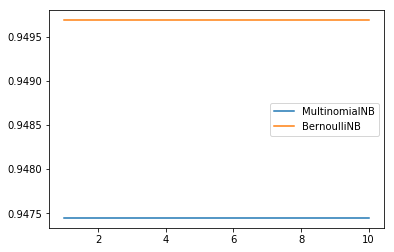

In [111]:
mnbs = []
bnbs = []
for i in range(10):
    mnb = MultinomialNB()
    mnb_s = cross_val_score(mnb,data_tf,dataSet[1],cv=10).mean()
    mnbs.append(mnb_s)
    bnb = BernoulliNB()
    bnb_s = cross_val_score(bnb,data_tf,dataSet[1],cv=10).mean()
    bnbs.append(bnb_s)
plt.plot(range(1,11),mnbs,label= 'MultinomialNB')
plt.plot(range(1,11),bnbs,label= 'BernoulliNB')
plt.legend()
plt.show()